# Different generation intervals

In this notebook we want to analyse the effect of different priors for the generation interval

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")
import seaborn as sns

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
#import covid19_inference as cov19
from header_plotting import *


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load_function(country, offset=0, mwd="1.0", interval_cps="10.0", f_fem="0.33", f_robust="1.0", len="normal", gen_interv="4.0"):
        fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/{folder}/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data={offset}"+
            f"-prior_delay=-1"+
            f"-median_width_delay={mwd}"+
            f"-interval_cps={interval_cps}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if not gen_interv == "4.0":
            fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
                f"-beta=False"+
                f"-country={country}"+
                f"-offset_data={offset}"+
                f"-prior_delay=-1"+
                f"-median_width_delay={mwd}"+
                f"-interval_cps={interval_cps}"+
                f"-f_fem={f_fem}"+
                f"-len=normal"+
                f"-abs_sine=False"+
                f"-f_robust=1.0"+
                f"-gen_interv={gen_interv}"+
                f"-t={tune}"+
                f"-d={draws}"+
                f"-max_treedepth={max_treedepth}.pkl")
        model = None
        
        tune, draws, max_treedepth = (2000, 4000, 12)
        folder="covid_uefa_traces14"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country}")
            
        tune, draws, max_treedepth = (1000, 2000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country}")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country}")
        
        if model is None: 
            print(fstr(tune, draws, max_treedepth, folder), " not found")
            return None, None
        
        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)
        return model, trace

In [4]:
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "../figures/SI"

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)


In [5]:
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
             'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
             'Netherlands']
tune = 2000
draws = 4000
max_treedepth = 12
traces, models, dls = {}, {}, {}
for country in tqdm(countries):
    models_t, traces_t, dls_t = [],[],[]
    for gen_interv in [4.0, 5.0, 6.0]:
        model,trace = load_function(country, gen_interv= gen_interv)

        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
        models_t.append(model)
        traces_t.append(trace)
        dls_t.append(dl)
    models[country] = models_t
    traces[country] = traces_t
    dls[country] = dls_t

  0%|          | 0/12 [00:00<?, ?it/s]

Use 2000 sample runs for England
Use 2000 sample runs for England
Use 2000 sample runs for England
Use 2000 sample runs for Czechia
Use 2000 sample runs for Czechia
Use 2000 sample runs for Czechia
Use 2000 sample runs for Scotland
Use 2000 sample runs for Scotland
Use 2000 sample runs for Scotland
Use 2000 sample runs for Spain
Use 2000 sample runs for Spain
Use 2000 sample runs for Spain
Use 2000 sample runs for Italy
Use 2000 sample runs for Italy
Use 2000 sample runs for Italy
Use 2000 sample runs for Slovakia
Use 2000 sample runs for Slovakia
Use 2000 sample runs for Slovakia
Use 2000 sample runs for Germany
Use 2000 sample runs for Germany
Use 2000 sample runs for Germany
Use 2000 sample runs for Austria
Use 2000 sample runs for Austria
Use 2000 sample runs for Austria
Use 2000 sample runs for Belgium
Use 2000 sample runs for Belgium
Use 2000 sample runs for Belgium
Use 2000 sample runs for France
Use 2000 sample runs for France
Use 2000 sample runs for France
Use 2000 sample run

In [6]:
# Compute interesting values as fractionv
primary_frac = []
for i, country in enumerate(countries):
    primary_frac_t = []
    
    for o in range(3):
        traces[country][o].posterior = traces[country][o].posterior.isel(draw=np.arange(-1000,0), chain=np.arange(6)) # make all the same shape
        frac_pr = covid19_soccer.plot.other.calc_fraction_primary(model=models[country][o], trace=traces[country][o], dl=dls[country][o])
        print(frac_pr.shape, country)
        primary_frac_t.append(frac_pr*100)
    primary_frac.append(np.array(primary_frac_t))

(6000, 2) England
(6000, 2) England
(6000, 2) England
(6000, 2) Czechia
(6000, 2) Czechia
(6000, 2) Czechia
(6000, 2) Scotland
(6000, 2) Scotland
(6000, 2) Scotland
(6000, 2) Spain
(6000, 2) Spain
(6000, 2) Spain
(6000, 2) Italy
(6000, 2) Italy
(6000, 2) Italy
(6000, 2) Slovakia
(6000, 2) Slovakia
(6000, 2) Slovakia
(6000, 2) Germany
(6000, 2) Germany
(6000, 2) Germany
(6000, 2) Austria
(6000, 2) Austria
(6000, 2) Austria
(6000, 2) Belgium
(6000, 2) Belgium
(6000, 2) Belgium
(6000, 2) France
(6000, 2) France
(6000, 2) France
(6000, 2) Portugal
(6000, 2) Portugal
(6000, 2) Portugal
(6000, 2) Netherlands
(6000, 2) Netherlands
(6000, 2) Netherlands


In [7]:
    
traces_overall=[]
primary_frac_for_model=[]
for i in range(3):
    #for l
    def reduce_samples_and_transpose(curr_list):
        number_of_samples = 500
        for i, array in enumerate(curr_list):
            array=array.T
            array.shape
            array = array[...,np.random.choice(array.shape[-1], number_of_samples, replace = False)]
            curr_list[i] = array
        return np.array(curr_list)

    primary_frac_for_model.append(reduce_samples_and_transpose([primary_frac[j][i] for j in range(len(countries))]))
    n_countries = len(countries)
    with pm.Model() as model:
        overall_effect = pm.Normal("overall_effect", mu=0, sigma=10, shape=(2,))
        tau = pm.HalfCauchy("tau", beta=10, shape=(2,))

        deviation = pm.Normal("deviation", mu=0, sigma=1, shape=(n_countries, 2))
        country_effect = deviation*tau + overall_effect
        country_effect = pm.Deterministic("country_effect", country_effect)

        sigma_obs = pm.HalfCauchy("sigma", beta=10, shape=(n_countries, 2))

        pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=primary_frac_for_model[i])

    with model:
        trace = pm.sample(tune=4000, draws=2000, chains=4, target_accept=0.95,
                          return_inferencedata=True)

        post_pred = pm.sample_posterior_predictive(trace)

    az.concat(trace, az.from_pymc3(posterior_predictive=post_pred), inplace=True)
    traces_overall.append(trace)

    
overall_effect = []
for i in range(3):
    overall_effect.append(get_from_trace("overall_effect", traces_overall[i]))
    

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 2300 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 2300 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, incr

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1643 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1643 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1633 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1633 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


[0 1 2]
Country	50.0	2.5	97.5	16	84	>0
England0	11.130549991124612	5.161551456191881	19.196598657221532	6.429199226933827	15.347377704876491	1.0
England1	10.543933529869129	4.766189496398102	18.404473500207377	6.327960870899777	15.273090439417516	1.0
England2	7.760287312601747	3.784759741055585	14.609009601845809	4.845833492364016	11.938907467742894	1.0
[1 0 2]
Country	50.0	2.5	97.5	16	84	>0
Czechia0	9.58810983866769	3.188567548659788	15.985885892253094	6.475558842851169	12.793884114912844	0.998
Czechia1	10.49136831399882	2.517187351437269	17.825606787519717	6.341403714945393	14.41824762777119	0.9986666666666667
Czechia2	8.488646226993618	1.2601316640354445	18.511177500238137	3.9404035348661477	13.784428289941244	0.994
[2 1 0]
Country	50.0	2.5	97.5	16	84	>0
Scotland0	3.1357019887324356	1.2391119523674505	7.994941397458571	1.6337308711313228	6.891252214170683	1.0
Scotland1	4.3417596470453805	1.7085897644382058	9.747109210433285	2.175744355538532	8.53721458461462	1.0
Scotland2	6.18421183

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


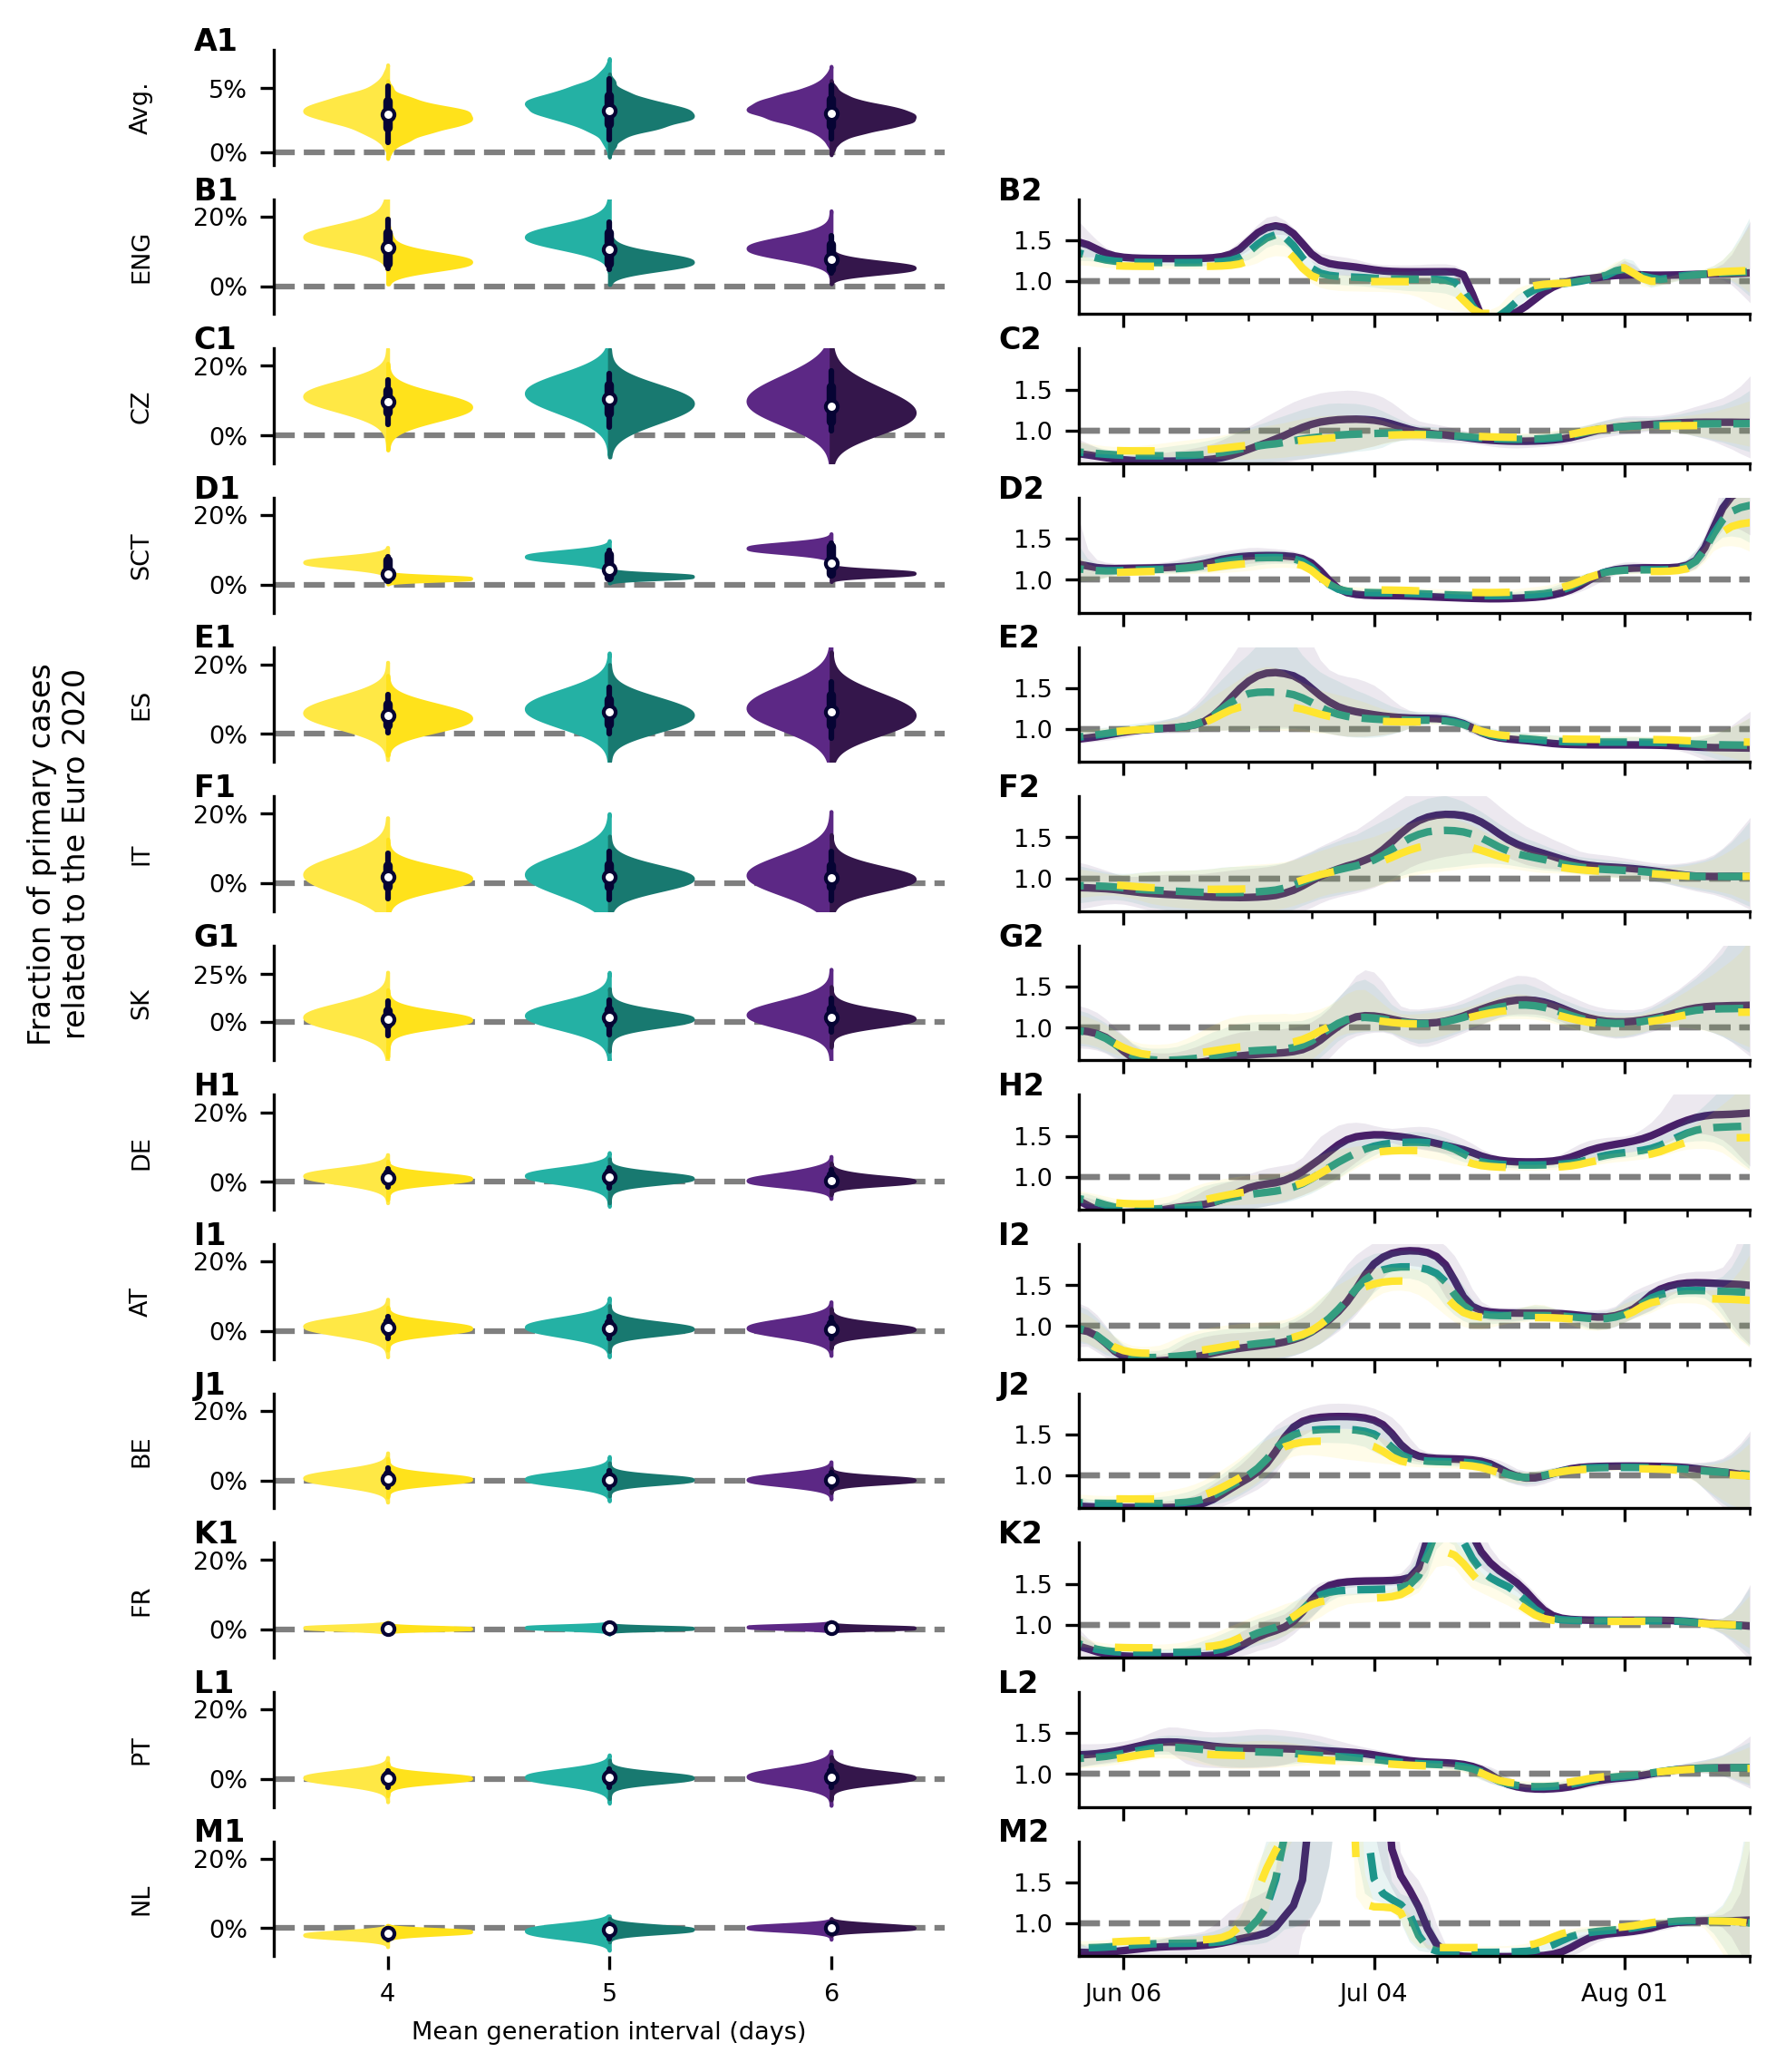

In [8]:
from covid19_soccer.plot.utils import lighten_color
from matplotlib.colors import to_hex
from covid19_soccer.plot.other import hviolins
import matplotlib.ticker as mtick

fig, axes = plt.subplots(len(countries)+1,2,figsize=(7,(len(countries)+1)*0.7),gridspec_kw={"hspace":0.3,"wspace":0.2})

colors_base = ["#ffe530","#1e958a","#481f68"]
l = 0.9
d = 1.1

colors_mf = []
for col in colors_base:
    colors_mf.append(to_hex(lighten_color(col,l)))
    colors_mf.append(to_hex(lighten_color(col,d)))
colors_mf = np.array(colors_mf)

def whisker_plot(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.spines["left"].set_visible(True)



ax = axes[0][0]
x = [array.T for array in overall_effect]
y = [0,1,2]
x_99ci = []
for i, yi in enumerate(y):
    ci = np.percentile(x[i][:, :], q=(0.5, 99.5), axis=1)

    data = []
    for g in [0, 1]:
        l, u = ci[:, g]
        mask = np.all([x[i][g, :] > l, x[i][g, :] < u], axis=0)
        data.append(x[i][g, mask])
    x_99ci.append(np.array(data))

df = pd.DataFrame(columns=["country", "gender", "values"])
for i, xi in enumerate(x_99ci):
    for g, gender in enumerate(["male", "female"]):
        temp_df = pd.DataFrame()
        temp_df["values"] = xi[g, :]
        temp_df["gender"] = gender
        temp_df["country"] = i
        df = pd.concat([df, temp_df])
g = sns.violinplot(
    data=df,
    y="values",
    x="country",
    hue="gender",
    scale="count",
    inner=None,
    orient="v",
    ax=ax,
    split=True,
    # palette={"male": color_male, "female": color_female},
    linewidth=1,
    saturation=1,
    width=0.75,
    #order=np.array(countries)[country_order],
)

c = 0
for i, col in enumerate(ax.collections):
    ax.collections[i].set_facecolor(colors_mf[i])
    ax.collections[i].set_edgecolor(colors_mf[i])  # Set outline colors


ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in overall_effect]
ci = np.array(ci).T    

whisker_plot(
    ax,
    [0,1,2],
    ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:]
    )

ax.legend([], [], frameon=False)
fmt = "%.0f%%"  # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)
ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(-1,8)

ax.set_ylabel("Avg.")
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

axes[0][1].set_visible(False)

for i, country in enumerate(countries):
    i = i+1
    covid19_soccer.plot.other.soccer_related_cases_overview(
        ax=axes[i,0],
        traces=traces[country],
        models=models[country],
        dls=dls[country],
        country_order=[0,1,2],
        colors=colors_mf,
        bw=1,
        remove_outliers=True
        )
    axes[i,0].set_xticklabels(["4","5","6"])
    axes[i,0].set_ylabel(dls[country][0].countries_iso2[0].replace("GB-",""))
    axes[i,0].yaxis.set_label_coords(-0.18, 0.5)

    if i != len(countries):
        axes[i,0].set_xticklabels([])
        axes[i,0].tick_params(bottom=False)

    for j, (trace, model , dl, color,ls) in enumerate(zip(traces[country], models[country], dls[country], colors_base, [(0, (5, 7)),"dashed","-"])):
        covid19_soccer.plot.timeseries.R_base(
            ax=axes[i,1],
            trace=trace,
            model=model,
            dl=dl,
            color=color,
            ls=ls,
            lw=2,
            zorder= 1 if j==1 else (2 if j==0 else 0)
        )
        axes[i,1].set_xlim(dl.data_begin,dl.data_end)
    axes[i,1].set_ylim(0.6,2)
    

# Array of capital letters
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))

# Add label letters to figure
for i in range(len(countries)+1):
    axes[i,0].text(
        -0.12,
        1.2,
        letters[i]+"1",
        transform=axes[i,0].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top"
    )
    if not i == 0:
        axes[i,1].text(
            -0.12,
            1.2,
            letters[i]+"2",
            transform=axes[i,1].transAxes,
            fontsize=8,
            fontweight="bold",
            verticalalignment="top"
        )

    if i != len(countries):
        axes[i,1].set_xticklabels([])
    axes[i,1].set_yticks([1,1.5])


# set ylims
ylims = {
    "England":[-8,25],
    "Czechia":[-8,25],
    "Italy":[-8,25],
    "Scotland":[-8,25],
    "Spain":[-8,25],
    "Germany":[-8,25],
    "France":[-8,25],
    'Slovakia':[-20,40],
    'Austria':[-8,25],
    'Belgium':[-8,25],
    'Portugal':[-8,25],
    'Netherlands':[-8,25],
}


for i, country in enumerate(countries):
    i = i+1
    axes[i,0].set_ylim(ylims[country])
    axes[i,1].set_ylabel("")


# Set overarching y label
axes[0,0].text(-0.32,-len(countries)/2,"Fraction of primary cases\nrelated to the Euro 2020",transform=axes[0,0].transAxes,rotation=90,ha="center",va="center",fontsize=8)
axes[0,1].text(-0.15,-len(countries)/2,"$R_\mathrm{base}$",transform=axes[0,1].transAxes,rotation=90,ha="center",va="center",fontsize=8)


axes[-1,0].set_xlabel("Mean generation interval (days)")

fig.savefig(f"{fig_path}/robustness_generation_interval.png", **save_kwargs)
fig.savefig(f"{fig_path}/robustness_generation_interval.pdf", **save_kwargs)

plt.show()
plt.close(fig=fig)

In [9]:
# Calc percentage of increase in infections
from covid19_soccer.plot.other import get_alpha_infections

countries_pi = ["Germany","France","Spain","Czechia"]

begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)
nums = []
meta = []
for c in countries_pi:
    for trace, model ,dl in zip(traces[c], models[c], dls[c]):
        infections_base, infections_alpha = get_alpha_infections(trace, model, dl)

        i_begin = (begin - model.sim_begin).days
        i_end = (end - model.sim_begin).days + 1  # inclusiv last day

        # Sum over the choosen range (i.e. month of uefa championship)
        num_infections_base = np.sum(infections_base[..., i_begin:i_end, :], axis=-2)
        num_infections_alpha = np.sum(infections_alpha[..., i_begin:i_end, :], axis=-2)

        # Create pandas dataframe for easy violin plot
        ratio_soccer = num_infections_alpha / (
            num_infections_base + num_infections_alpha
        )
        
        nums.append(np.mean(ratio_soccer))
        meta.append(c)




In [10]:
i = 0
for c in countries_pi:
    print(c)
    print("ffem_0.2",nums[i])
    print("ffem_0.5",nums[i+1])
    print("increase",(nums[i+1]-nums[i])/(nums[i]))
    i += 2



Germany
ffem_0.2 0.03366658885272393
ffem_0.5 0.03488428856844088
increase 0.03616938208512395
France
ffem_0.2 0.016776585000899125
ffem_0.5 0.02236102984123364
increase 0.33287137042701015
Spain
ffem_0.2 0.024938985447723345
ffem_0.5 0.03188021939944281
increase 0.2783286419677961
Czechia
ffem_0.2 0.10603817837161202
ffem_0.5 0.12255406115257207
increase 0.15575411643794893


In [11]:
calc_increase(ratios_soccer,1).shape

NameError: name 'calc_increase' is not defined

## Extended overviews

In [ ]:
from covid19_soccer.plot.overview import single_extended
for trace,model,dl in zip(traces.values(),models.values(),dls.values()):
    
    fig0 = single_extended(trace[0],model[0],dl[0])
    fig0.suptitle(f"{dl[0].countries[0]}")
    fig1 = single_extended(trace[1],model[1],dl[1])
    fig1.suptitle(f"{dl[1].countries[0]}")
    plt.show()
    plt.close(fig=fig0)
    plt.close(fig=fig1)

In [ ]:
np.percentile(traces["Netherlands"][1].posterior['sigma_lambda_cp_noise'], q=(2.5,50, 97.5))